### Task 2 (major task): Write a classifier using any AI/ML technique to classify a given novel set of abstracts into the four classes given above. Perform n-fold cross validation and provide performance metrics for the classification.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
from __future__ import print_function
import tqdm
import string

In [2]:
df1 = pd.read_csv('data.csv')

In [3]:
df1['Abstract'] = df1['title'].str.cat(df1['abstract'], sep =".") 
df1.head()

,pmid,title,key words,abstract,Label,Abstract
0,25972284,The Impact of Oral Intake of Dydrogesterone on...,"['Congenital', 'heart', 'disease', 'Dydrogeste...",Congenital heart disease is the most frequent ...,congenital anomalies caused by drug usage,The Impact of Oral Intake of Dydrogesterone on...
1,28216061,Outcomes After Primary Percutaneous Coronary I...,"['Coronary', 'aneurysm', 'Coronary', 'artery',...",There is minimal published data on outcomes of...,congenital anomalies caused by drug usage,Outcomes After Primary Percutaneous Coronary I...
2,31079148,Long-term proarrhythmic pharmacotherapy among ...,"['Adverse', 'drug', 'events', 'Congenital', 'l...",It is Class I recommendation that congenital l...,congenital anomalies caused by drug usage,Long-term proarrhythmic pharmacotherapy among ...
3,24656122,[Drug-induced QT interval prolongation: do we ...,"['Drug', 'interactions', 'Drugs', 'Factores', ...",Sudden cardiac death is an important cause of ...,congenital anomalies caused by drug usage,[Drug-induced QT interval prolongation: do we ...
4,27272693,Dexmedetomidine is Associated with an Increase...,"['Adverse', 'drug', 'event', 'Cardiac', 'surge...",This study aimed to evaluate adverse cardiac e...,congenital anomalies caused by drug usage,Dexmedetomidine is Associated with an Increase...


In [4]:
df = df1[['pmid','Abstract','Label']]
df.head()

,pmid,Abstract,Label
0,25972284,The Impact of Oral Intake of Dydrogesterone on...,congenital anomalies caused by drug usage
1,28216061,Outcomes After Primary Percutaneous Coronary I...,congenital anomalies caused by drug usage
2,31079148,Long-term proarrhythmic pharmacotherapy among ...,congenital anomalies caused by drug usage
3,24656122,[Drug-induced QT interval prolongation: do we ...,congenital anomalies caused by drug usage
4,27272693,Dexmedetomidine is Associated with an Increase...,congenital anomalies caused by drug usage


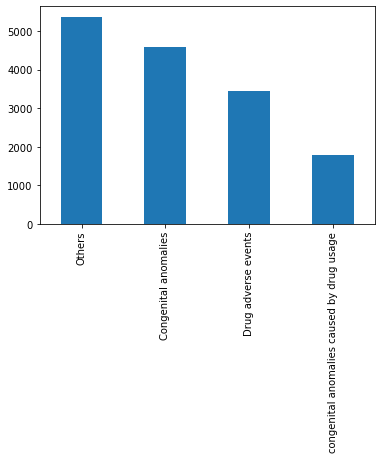

In [5]:
fig, ax = plt.subplots()
df['Label'].value_counts().plot(ax=ax, kind='bar')

In [6]:
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', str(data))
striphtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a>')

'I Want This text!'

In [8]:
df['Abstract'] = df['Abstract'].apply(striphtml)
df['Abstract'] = df['Abstract'].apply(str)

In [9]:
df.to_csv('data1.csv',index=False)

# Building Models

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from gensim.models import Doc2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec
from gensim.scripts.glove2word2vec import glove2word2vec

import scikitplot.plotters as skplt

import nltk
from nltk.corpus import stopwords

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [11]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=8, stratify=df['Label'])
print(df_train.shape,df_test.shape)

(10655, 3) (4567, 3)


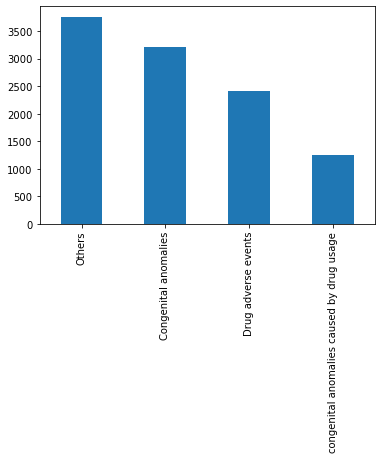

In [12]:
fig, ax = plt.subplots()
df_train['Label'].value_counts().plot(ax=ax, kind='bar')

In [13]:
# Evaluate the effectiveness of transformed free text. 
def evaluate_features(X,y,clf=None):
    """Prints log loss,acuracy and confusion matrix with 
    k-fold stratified cross-validation"""
    """X: features array (n_samples,n_features)
       y: labels array (n_samples,)
       clf: Classifier"""
    
    if clf is None:
        clf=LogisticRegression()
    probas = cross_val_predict(clf,X,y,cv=StratifiedKFold(n_splits=5,random_state=8),n_jobs=-1,method='predict_proba',verbose=2)
    pred_indices = np.argmax(probas,axis=1)
    classes=np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    print(classification_report(y, preds, labels=classes))
    skplt.plot_confusion_matrix(y, preds)
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Log loss: 0.13995479870616745
Accuracy: 0.9733333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



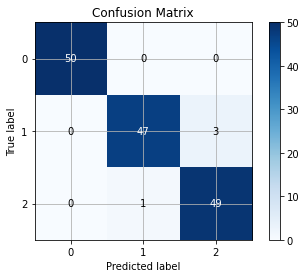

In [14]:
# Testing on iris dataset
from sklearn.datasets import load_iris
evaluate_features(*load_iris(True))

# BAG of Words

In [25]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

In [26]:
bag_of_words = count_vectorizer.fit_transform(df_train['Abstract'])

In [23]:
# no.of unique words in corpus
len(count_vectorizer.get_feature_names())

55356

In [17]:
svd = TruncatedSVD(n_components=25,n_iter=25,random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Log loss: 0.3487572187301398
Accuracy: 0.8814641013608634
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.85      0.91      0.88      3218
                      Drug adverse events       0.93      0.95      0.94      2420
                                   Others       0.90      0.93      0.91      3761
congenital anomalies caused by drug usage       0.78      0.54      0.64      1256

                                 accuracy                           0.88     10655
                                macro avg       0.86      0.83      0.84     10655
                             weighted avg       0.88      0.88      0.88     10655



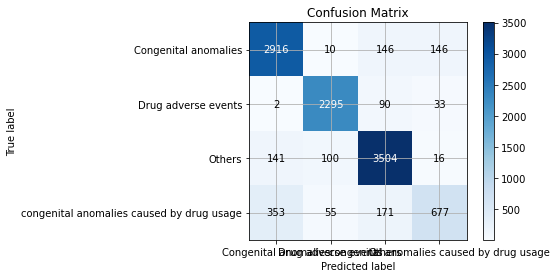

In [18]:
evaluate_features(truncated_bag_of_words, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.4s finished


Log loss: 0.6554783655209746
Accuracy: 0.8041295166588456
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.74      0.94      0.82      3218
                      Drug adverse events       0.89      0.90      0.89      2420
                                   Others       0.82      0.90      0.86      3761
congenital anomalies caused by drug usage       1.00      0.01      0.01      1256

                                 accuracy                           0.80     10655
                                macro avg       0.86      0.68      0.65     10655
                             weighted avg       0.83      0.80      0.76     10655



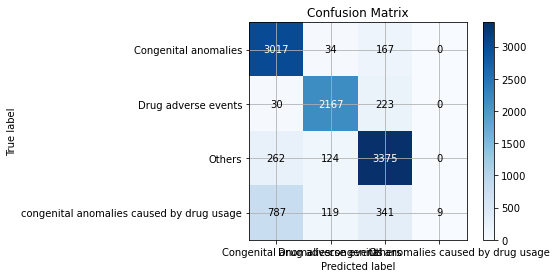

In [19]:
evaluate_features(truncated_bag_of_words, df_train['Label'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.2s finished


Log loss: 0.30956519344738365
Accuracy: 0.9194744251525105
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.90      0.91      0.91      3218
                      Drug adverse events       0.96      0.97      0.97      2420
                                   Others       0.94      0.95      0.95      3761
congenital anomalies caused by drug usage       0.81      0.74      0.77      1256

                                 accuracy                           0.92     10655
                                macro avg       0.90      0.89      0.90     10655
                             weighted avg       0.92      0.92      0.92     10655



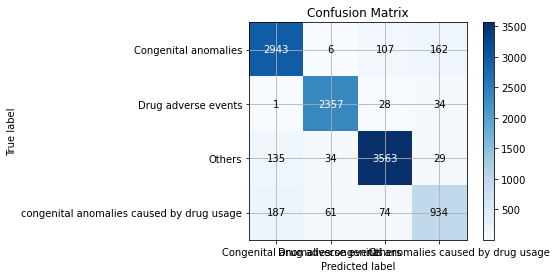

In [20]:
evaluate_features(bag_of_words, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.7s finished


Log loss: 0.3362809065520731
Accuracy: 0.8859690286250587
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.86      0.91      0.88      3218
                      Drug adverse events       0.95      0.94      0.94      2420
                                   Others       0.89      0.94      0.92      3761
congenital anomalies caused by drug usage       0.78      0.57      0.66      1256

                                 accuracy                           0.89     10655
                                macro avg       0.87      0.84      0.85     10655
                             weighted avg       0.88      0.89      0.88     10655



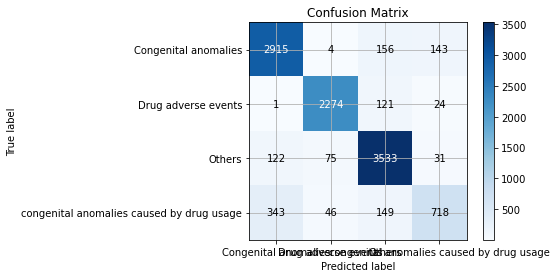

In [22]:
evaluate_features(truncated_bag_of_words, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Log loss: 0.2597396590688565
Accuracy: 0.9134678554669169
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.89      0.91      0.90      3218
                      Drug adverse events       0.96      0.97      0.97      2420
                                   Others       0.94      0.95      0.94      3761
congenital anomalies caused by drug usage       0.79      0.72      0.75      1256

                                 accuracy                           0.91     10655
                                macro avg       0.90      0.89      0.89     10655
                             weighted avg       0.91      0.91      0.91     10655



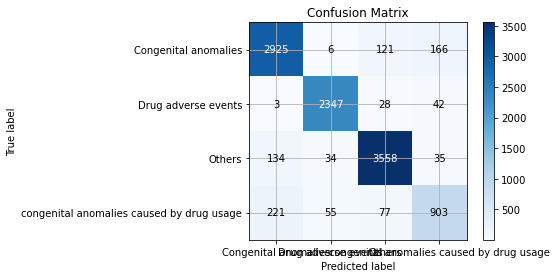

In [21]:
evaluate_features(bag_of_words, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

**ON test data**

In [27]:
bow_test = count_vectorizer.transform(df_test['Abstract'])

In [31]:
lr_BOW = LogisticRegression()
lr_BOW.fit(bag_of_words,df_train['Label'].values)

LogisticRegression()

Log loss: 0.3365611209782367
Accuracy: 0.9156995839719728
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.90      0.90      0.90      1379
                      Drug adverse events       0.96      0.98      0.97      1038
                                   Others       0.94      0.95      0.95      1612
congenital anomalies caused by drug usage       0.79      0.73      0.76       538

                                 accuracy                           0.92      4567
                                macro avg       0.90      0.89      0.89      4567
                             weighted avg       0.91      0.92      0.91      4567



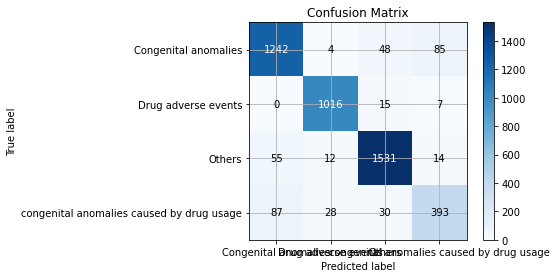

In [37]:
y=df_test['Label'].values
probas = lr_BOW.predict_proba(bow_test)
pred_indices = np.argmax(probas,axis=1)
classes=np.unique(y)
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y, probas)))
print('Accuracy: {}'.format(accuracy_score(y, preds)))
print(classification_report(y, preds, labels=classes))
skplt.plot_confusion_matrix(y, preds)

# TF-IDF

In [38]:
count_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(df_train['Abstract'])

len(count_vectorizer.get_feature_names())

94986

In [24]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Log loss: 0.4282771242689064
Accuracy: 0.8626935710933834
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.84      0.91      0.87      3218
                      Drug adverse events       0.93      0.94      0.93      2420
                                   Others       0.85      0.93      0.89      3761
congenital anomalies caused by drug usage       0.80      0.40      0.53      1256

                                 accuracy                           0.86     10655
                                macro avg       0.85      0.79      0.81     10655
                             weighted avg       0.86      0.86      0.85     10655



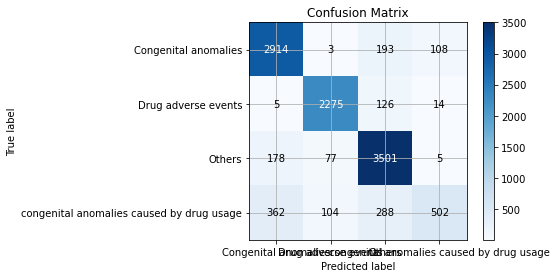

In [25]:
evaluate_features(truncated_tfidf, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.5s finished


Log loss: 0.6041359610570608
Accuracy: 0.8110746128578132
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.73      0.95      0.83      3218
                      Drug adverse events       0.93      0.90      0.92      2420
                                   Others       0.82      0.89      0.85      3761
congenital anomalies caused by drug usage       0.89      0.05      0.10      1256

                                 accuracy                           0.81     10655
                                macro avg       0.84      0.70      0.67     10655
                             weighted avg       0.83      0.81      0.77     10655



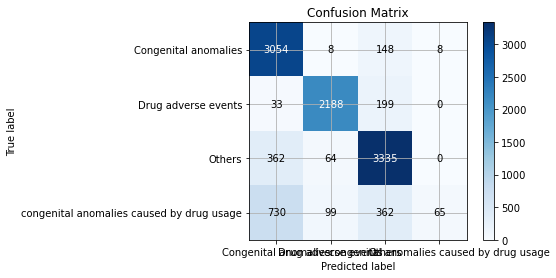

In [26]:
evaluate_features(truncated_tfidf, df_train['Label'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


Log loss: 0.33921178904603544
Accuracy: 0.8772407320506804
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.86      0.89      0.87      3218
                      Drug adverse events       0.93      0.94      0.94      2420
                                   Others       0.90      0.92      0.91      3761
congenital anomalies caused by drug usage       0.73      0.59      0.65      1256

                                 accuracy                           0.88     10655
                                macro avg       0.85      0.84      0.84     10655
                             weighted avg       0.87      0.88      0.87     10655



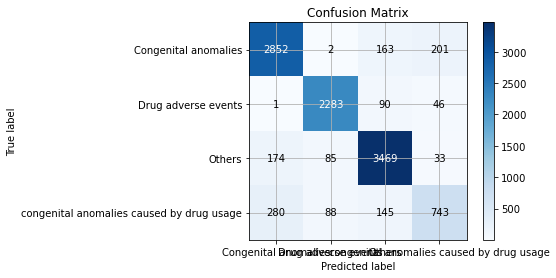

In [27]:
evaluate_features(truncated_tfidf, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.4min finished


Log loss: 0.22394896224674676
Accuracy: 0.9248240262787424
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.91      0.92      0.92      3218
                      Drug adverse events       0.96      0.97      0.97      2420
                                   Others       0.95      0.95      0.95      3761
congenital anomalies caused by drug usage       0.82      0.77      0.79      1256

                                 accuracy                           0.92     10655
                                macro avg       0.91      0.90      0.91     10655
                             weighted avg       0.92      0.92      0.92     10655



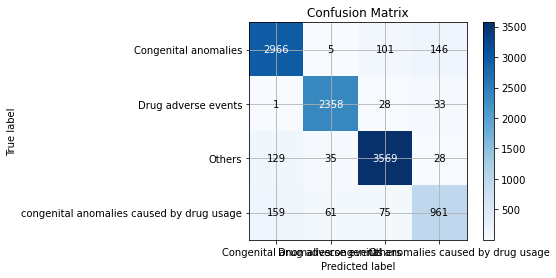

In [28]:
evaluate_features(tfidf, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

**On test data**

In [39]:
tf_test = count_vectorizer.transform(df_test['Abstract'])

In [41]:
svc_tfid = SVC(kernel='linear', probability=True)
svc_tfid.fit(tfidf,df_train['Label'].values)

SVC(kernel='linear', probability=True)

Log loss: 0.23992789080420793
Accuracy: 0.919202977884826
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.90      0.92      0.91      1379
                      Drug adverse events       0.96      0.97      0.97      1038
                                   Others       0.95      0.94      0.95      1612
congenital anomalies caused by drug usage       0.79      0.75      0.77       538

                                 accuracy                           0.92      4567
                                macro avg       0.90      0.90      0.90      4567
                             weighted avg       0.92      0.92      0.92      4567



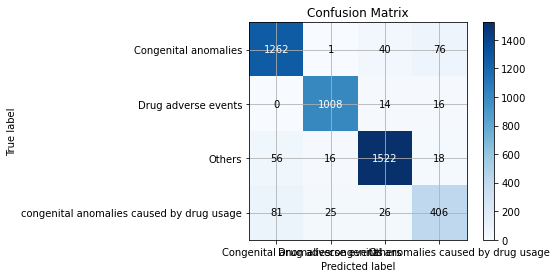

In [43]:
y=df_test['Label'].values
probas = svc_tfid.predict_proba(tf_test)
pred_indices = np.argmax(probas,axis=1)
classes=np.unique(y)
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y, probas)))
print('Accuracy: {}'.format(accuracy_score(y, preds)))
print(classification_report(y, preds, labels=classes))
skplt.plot_confusion_matrix(y, preds)

# Word2vec

In [44]:
# Creating a class which generates/produces a list of tokenzied sentences
class MySentences(object):
    def __init__(self,*arrays):
        self.arrays=arrays
        
    def __iter__(self):
        for array in self.arrays:
            for doc in array:
                for sent in nltk.sent_tokenize(doc):
                    yield nltk.word_tokenize(sent)

In [45]:
# Return trained word2vec 
def get_word2vec(sentences,location,size=10):
    if os.path.exists(location):
        print("Loading model")
        model = gensim.models.Word2Vec.load(location)
        return model
    print("Not found, Training model")
    model = gensim.models.Word2Vec(sentences,size=size,window=5,min_count=5,workers=4)
    model.save(location)
    return model

Now we have w2v model, we can transform each doc into a feature vector. In order to convert a doc of multiple words into a single vector we take w2v of all words in doc and take its mean.

In [46]:
# Converts doc into corresponding tokens
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        transformed_X = []
        for doc in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(doc):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self,X,y=None):
        return self.transform(X)

In [47]:
# Converts doc into corresponding vector
class MeanEmbeddingVectorizer(object):
    def __init__(self,word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.wv.syn0[0])
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X = MyTokenizer().fit_transform(X)
        # takes mean of all word vectors, if word is not in w2v we return a vector of 0 with same dimensions
        return np.array([np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv] or [np.zeros(self.dim)],axis=0) for words in X])
    
    def fit_transform(self,X,y=None):
        return self.transform(X)

In [48]:
# Training with dimension vector 100
w2v = get_word2vec(MySentences(df['Abstract'].values),'w2vmodel',size=100)
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train['Abstract'])

Loading model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Log loss: 0.37473339488661905
Accuracy: 0.86353824495542
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.85      0.88      0.87      3218
                      Drug adverse events       0.92      0.93      0.93      2420
                                   Others       0.87      0.90      0.89      3761
congenital anomalies caused by drug usage       0.72      0.57      0.64      1256

                                 accuracy                           0.86     10655
                                macro avg       0.84      0.82      0.83     10655
                             weighted avg       0.86      0.86      0.86     10655



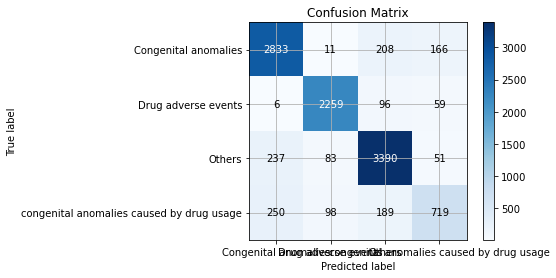

In [35]:
evaluate_features(mean_embedded, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Log loss: 0.3638097755152188
Accuracy: 0.8687001407789771
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.86      0.88      0.87      3218
                      Drug adverse events       0.93      0.94      0.93      2420
                                   Others       0.88      0.91      0.89      3761
congenital anomalies caused by drug usage       0.72      0.60      0.65      1256

                                 accuracy                           0.87     10655
                                macro avg       0.85      0.83      0.84     10655
                             weighted avg       0.87      0.87      0.87     10655



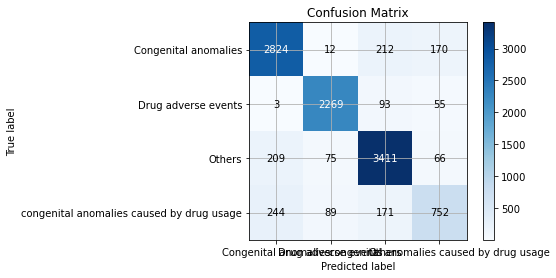

In [36]:
evaluate_features(mean_embedded, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


Log loss: 0.5728955601718608
Accuracy: 0.8164242139840451
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.77      0.90      0.83      3218
                      Drug adverse events       0.88      0.91      0.90      2420
                                   Others       0.83      0.84      0.83      3761
congenital anomalies caused by drug usage       0.77      0.35      0.48      1256

                                 accuracy                           0.82     10655
                                macro avg       0.81      0.75      0.76     10655
                             weighted avg       0.82      0.82      0.80     10655



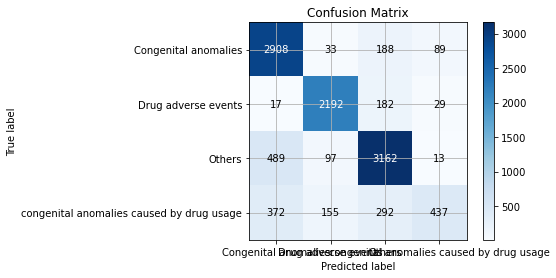

In [37]:
evaluate_features(mean_embedded, df_train['Label'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Log loss: 0.6075281451364908
Accuracy: 0.7961520412951666
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.75      0.89      0.81      3218
                      Drug adverse events       0.87      0.88      0.87      2420
                                   Others       0.81      0.83      0.82      3761
congenital anomalies caused by drug usage       0.67      0.32      0.43      1256

                                 accuracy                           0.80     10655
                                macro avg       0.78      0.73      0.73     10655
                             weighted avg       0.79      0.80      0.78     10655



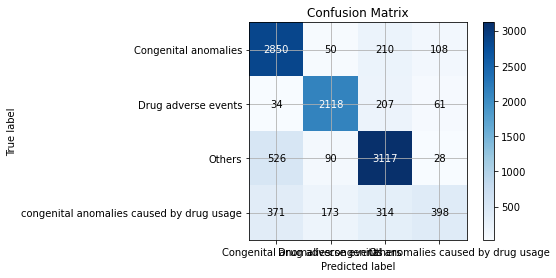

In [38]:
evaluate_features(mean_embedded,df_train['Label'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,))

In [49]:
# Training with dimension vector 300
w2v = get_word2vec(MySentences(df['Abstract'].values),'w2vmodel3',size=300)
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v)
mean_embedded = mean_embedding_vectorizer.fit_transform(df_train['Abstract'])

Loading model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Log loss: 0.353335331638377
Accuracy: 0.8726419521351478
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.86      0.89      0.88      3218
                      Drug adverse events       0.93      0.94      0.93      2420
                                   Others       0.88      0.91      0.90      3761
congenital anomalies caused by drug usage       0.74      0.59      0.65      1256

                                 accuracy                           0.87     10655
                                macro avg       0.85      0.83      0.84     10655
                             weighted avg       0.87      0.87      0.87     10655



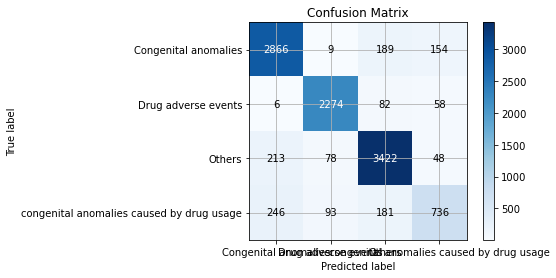

In [40]:
evaluate_features(mean_embedded, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Log loss: 0.33935154704671305
Accuracy: 0.8797747536367903
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.87      0.89      0.88      3218
                      Drug adverse events       0.93      0.94      0.94      2420
                                   Others       0.89      0.92      0.91      3761
congenital anomalies caused by drug usage       0.75      0.62      0.68      1256

                                 accuracy                           0.88     10655
                                macro avg       0.86      0.84      0.85     10655
                             weighted avg       0.88      0.88      0.88     10655



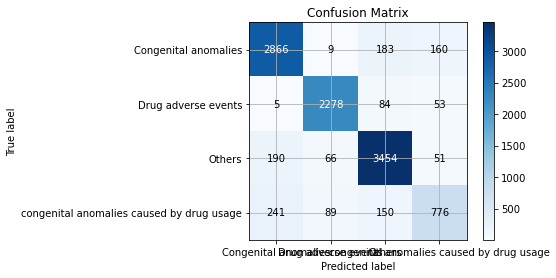

In [41]:
evaluate_features(mean_embedded, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


Log loss: 0.5548950896412868
Accuracy: 0.8244955419990615
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.78      0.91      0.84      3218
                      Drug adverse events       0.89      0.91      0.90      2420
                                   Others       0.83      0.85      0.84      3761
congenital anomalies caused by drug usage       0.81      0.35      0.49      1256

                                 accuracy                           0.82     10655
                                macro avg       0.83      0.76      0.77     10655
                             weighted avg       0.83      0.82      0.81     10655



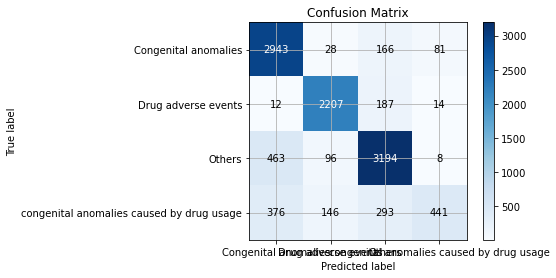

In [42]:
evaluate_features(mean_embedded, df_train['Label'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min finished


Log loss: 0.5597433743728321
Accuracy: 0.8180197090567809
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.77      0.91      0.83      3218
                      Drug adverse events       0.89      0.91      0.90      2420
                                   Others       0.84      0.84      0.84      3761
congenital anomalies caused by drug usage       0.72      0.37      0.49      1256

                                 accuracy                           0.82     10655
                                macro avg       0.80      0.75      0.76     10655
                             weighted avg       0.81      0.82      0.81     10655



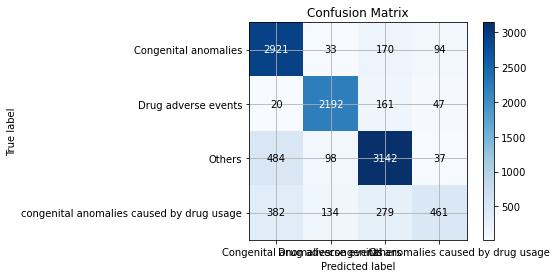

In [43]:
evaluate_features(mean_embedded,df_train['Label'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,))

**On test data**

In [51]:
svc_w2v = SVC(kernel='linear', probability=True)
svc_w2v.fit(mean_embedded,df_train['Label'])

SVC(kernel='linear', probability=True)

In [52]:
mean_embedded_test = mean_embedding_vectorizer.transform(df_test['Abstract'])

Log loss: 0.35266512493052665
Accuracy: 0.8736588570177359
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.87      0.87      0.87      1379
                      Drug adverse events       0.94      0.94      0.94      1038
                                   Others       0.89      0.92      0.90      1612
congenital anomalies caused by drug usage       0.69      0.63      0.66       538

                                 accuracy                           0.87      4567
                                macro avg       0.85      0.84      0.84      4567
                             weighted avg       0.87      0.87      0.87      4567



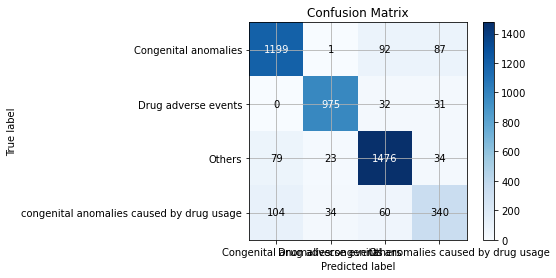

In [54]:
y = df_test['Label'].values
probas = svc_w2v.predict_proba(mean_embedded_test)
pred_indices = np.argmax(probas,axis=1)
classes=np.unique(y)
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y, probas)))
print('Accuracy: {}'.format(accuracy_score(y, preds)))
print(classification_report(y, preds, labels=classes))
skplt.plot_confusion_matrix(y, preds)

## Using pretrained w2v models

In [55]:
glove = 'glove.840B.300d.txt'
pubmed = 'PubMed-and-PMC-w2v.bin'

###### GLOVE Embedding

In [56]:
glove_file = datapath(glove)
tmp_file = get_tmpfile("glove.txt")
glove2word2vec(glove_file, tmp_file)

(2196017, 300)

In [57]:
w2v_glove = KeyedVectors.load_word2vec_format(tmp_file)

In [58]:
embedding_vectorizer = MeanEmbeddingVectorizer(w2v_glove)
embed = embedding_vectorizer.fit_transform(df_train['Abstract'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.5s finished


Log loss: 0.36705479461840473
Accuracy: 0.8732989206945097
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.85      0.90      0.87      3218
                      Drug adverse events       0.93      0.95      0.94      2420
                                   Others       0.88      0.89      0.89      3761
congenital anomalies caused by drug usage       0.79      0.61      0.68      1256

                                 accuracy                           0.87     10655
                                macro avg       0.86      0.84      0.85     10655
                             weighted avg       0.87      0.87      0.87     10655



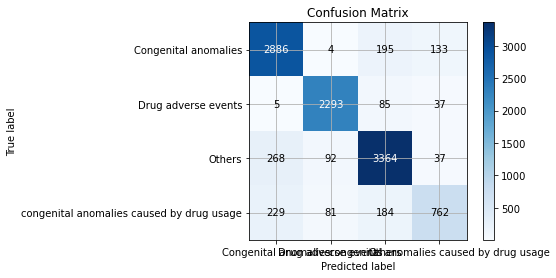

In [53]:
evaluate_features(embed, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Log loss: 0.33479807725955824
Accuracy: 0.8820272172688879
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.87      0.89      0.88      3218
                      Drug adverse events       0.94      0.95      0.95      2420
                                   Others       0.89      0.90      0.89      3761
congenital anomalies caused by drug usage       0.78      0.66      0.71      1256

                                 accuracy                           0.88     10655
                                macro avg       0.87      0.85      0.86     10655
                             weighted avg       0.88      0.88      0.88     10655



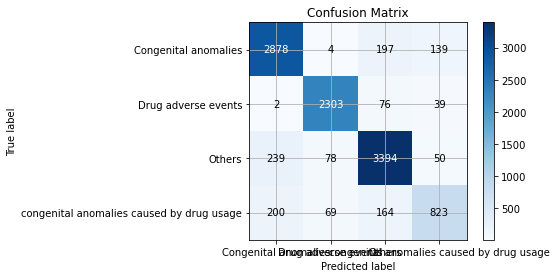

In [54]:
evaluate_features(embed, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Log loss: 0.5579159387686575
Accuracy: 0.8273111215391835
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.79      0.92      0.85      3218
                      Drug adverse events       0.89      0.92      0.90      2420
                                   Others       0.82      0.84      0.83      3761
congenital anomalies caused by drug usage       0.84      0.37      0.52      1256

                                 accuracy                           0.83     10655
                                macro avg       0.84      0.76      0.78     10655
                             weighted avg       0.83      0.83      0.82     10655



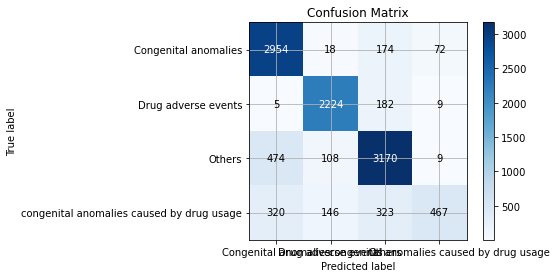

In [55]:
evaluate_features(embed, df_train['Label'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished


Log loss: 0.5555711857411627
Accuracy: 0.8167996245893947
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.77      0.90      0.83      3218
                      Drug adverse events       0.87      0.91      0.89      2420
                                   Others       0.83      0.82      0.82      3761
congenital anomalies caused by drug usage       0.76      0.41      0.53      1256

                                 accuracy                           0.82     10655
                                macro avg       0.81      0.76      0.77     10655
                             weighted avg       0.82      0.82      0.81     10655



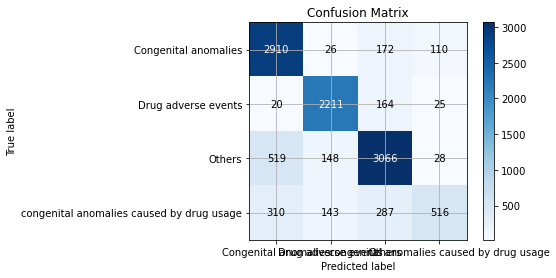

In [56]:
evaluate_features(embed,df_train['Label'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,))

**On test data**

Log loss: 0.3402662767244844
Accuracy: 0.8782570615283556
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.86      0.88      0.87      1379
                      Drug adverse events       0.95      0.95      0.95      1038
                                   Others       0.88      0.90      0.89      1612
congenital anomalies caused by drug usage       0.76      0.69      0.72       538

                                 accuracy                           0.88      4567
                                macro avg       0.86      0.85      0.86      4567
                             weighted avg       0.88      0.88      0.88      4567



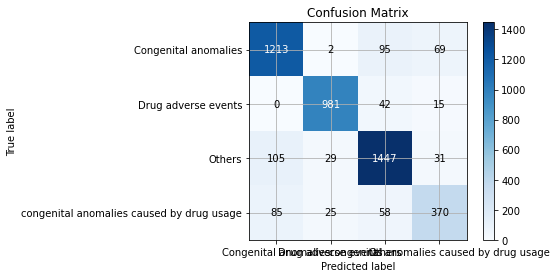

In [59]:
svc_w2vg = SVC(kernel='linear', probability=True)
svc_w2vg.fit(embed,df_train['Label'])

mean_embedded_test = embedding_vectorizer.transform(df_test['Abstract'])

y = df_test['Label'].values
probas = svc_w2vg.predict_proba(mean_embedded_test)
pred_indices = np.argmax(probas,axis=1)
classes=np.unique(y)
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y, probas)))
print('Accuracy: {}'.format(accuracy_score(y, preds)))
print(classification_report(y, preds, labels=classes))
skplt.plot_confusion_matrix(y, preds)

##### Pubmed bigram embedding

In [60]:
w2v_pub = KeyedVectors.load_word2vec_format(pubmed,binary=True) 

In [61]:
embedding = MeanEmbeddingVectorizer(w2v_pub)
embed_pub = embedding.fit_transform(df_train['Abstract'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.5s finished


Log loss: 0.44993220418445257
Accuracy: 0.8482402627874237
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.82      0.89      0.85      3218
                      Drug adverse events       0.92      0.95      0.93      2420
                                   Others       0.84      0.86      0.85      3761
congenital anomalies caused by drug usage       0.81      0.52      0.64      1256

                                 accuracy                           0.85     10655
                                macro avg       0.85      0.80      0.82     10655
                             weighted avg       0.85      0.85      0.84     10655



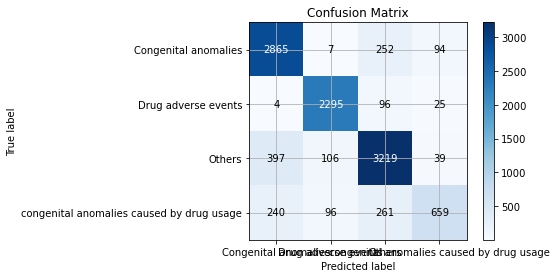

In [78]:
evaluate_features(embed_pub, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Log loss: 0.3349833370488183
Accuracy: 0.8822149225715626
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.87      0.89      0.88      3218
                      Drug adverse events       0.94      0.95      0.95      2420
                                   Others       0.89      0.90      0.89      3761
congenital anomalies caused by drug usage       0.78      0.66      0.71      1256

                                 accuracy                           0.88     10655
                                macro avg       0.87      0.85      0.86     10655
                             weighted avg       0.88      0.88      0.88     10655



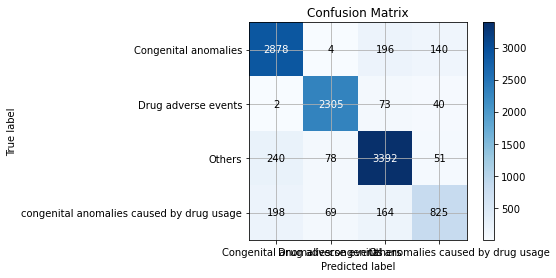

In [79]:
evaluate_features(embed, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


Log loss: 0.5565024967202259
Accuracy: 0.8290943219145941
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.79      0.92      0.85      3218
                      Drug adverse events       0.89      0.92      0.91      2420
                                   Others       0.83      0.84      0.84      3761
congenital anomalies caused by drug usage       0.84      0.39      0.53      1256

                                 accuracy                           0.83     10655
                                macro avg       0.84      0.77      0.78     10655
                             weighted avg       0.83      0.83      0.82     10655



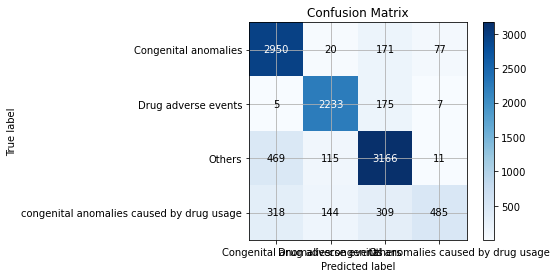

In [80]:
evaluate_features(embed, df_train['Label'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min finished


Log loss: 0.5555711857411627
Accuracy: 0.8167996245893947
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.77      0.90      0.83      3218
                      Drug adverse events       0.87      0.91      0.89      2420
                                   Others       0.83      0.82      0.82      3761
congenital anomalies caused by drug usage       0.76      0.41      0.53      1256

                                 accuracy                           0.82     10655
                                macro avg       0.81      0.76      0.77     10655
                             weighted avg       0.82      0.82      0.81     10655



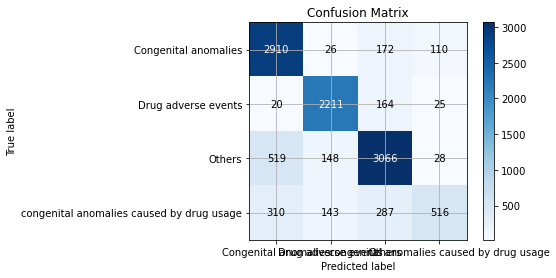

In [81]:
evaluate_features(embed,df_train['Label'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,))

**On test data**

Log loss: 0.4115939353946783
Accuracy: 0.8478213269104445
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.83      0.86      0.84      1379
                      Drug adverse events       0.94      0.93      0.94      1038
                                   Others       0.84      0.86      0.85      1612
congenital anomalies caused by drug usage       0.73      0.62      0.67       538

                                 accuracy                           0.85      4567
                                macro avg       0.83      0.82      0.83      4567
                             weighted avg       0.85      0.85      0.85      4567



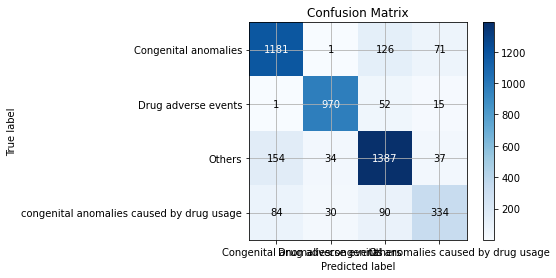

In [62]:
svc_w2vp = SVC(kernel='linear', probability=True)
svc_w2vp.fit(embed_pub,df_train['Label'])

mean_embedded_test = embedding.transform(df_test['Abstract'])

y = df_test['Label'].values
probas = svc_w2vp.predict_proba(mean_embedded_test)
pred_indices = np.argmax(probas,axis=1)
classes=np.unique(y)
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y, probas)))
print('Accuracy: {}'.format(accuracy_score(y, preds)))
print(classification_report(y, preds, labels=classes))
skplt.plot_confusion_matrix(y, preds)

**Creating a embedding matrix for keras**

In [115]:
vocab_size = 1000
oov_token = "<OOV>"
max_length = 300
padding_type = "post"
trunction_type = "post"

In [116]:
tokenizer = Tokenizer(num_words = vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(df_train['Abstract'].values)
word_index = tokenizer.word_index

In [117]:
X = tokenizer.texts_to_sequences(df_train['Abstract'].values)
X = pad_sequences(X, maxlen=max_length,padding=padding_type,truncating=trunction_type)

In [118]:
X_test = tokenizer.texts_to_sequences(df_test['Abstract'].values)
X_test = pad_sequences(X_test, maxlen=max_length,padding=padding_type,truncating=trunction_type)

In [113]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(glove,encoding='utf8'))

In [119]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [121]:
np.save('trainglove.npy',X)
np.save('testglove.npy',X_test)
np.save('glovembed',embedding_matrix)

# Doc2Vec

In [58]:
def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

In [59]:
def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [60]:
df_n = pd.concat([df_train,df_test])
df_n.head()

,pmid,Abstract,Label
3857,25577202,Prevalence of birth defects in an Arctic Russi...,Congenital anomalies
12033,26696568,NERI: network-medicine based integrative appro...,Others
1820,32504567,How often do we incidentally find a fetal abno...,Congenital anomalies
14557,31055931,Surface-Enhanced Raman Analysis of Underlaying...,Others
10349,30854389,Latest update about virtual-assisted lung mapp...,Others


In [61]:
Text = df_n['Abstract'].apply(cleanup)
sentences = constructLabeledSentences(Text)

In [62]:
sentences[0]

LabeledSentence(words=['prevalence', 'birth', 'defects', 'arctic', 'russian', 'setting', '1973', '2011', 'registerbased', 'studybirth', 'defects', 'bd', 'constitute', 'important', 'public', 'health', 'issue', 'main', 'cause', 'infant', 'death', 'prevalence', 'europe', '20082012', '256', 'per', '1000', 'newborns', 'date', 'populationbased', 'studies', 'russian', 'federation', 'aim', 'present', 'study', 'estimate', 'prevalence', 'bd', 'forms', 'changes', 'time', 'russian', 'arctic', 'city', 'monchegorsk', 'murmansk', 'county', 'period', '19732011the', 'murmansk', 'county', 'birth', 'register', 'kola', 'birth', 'register', 'primary', 'sources', 'information', 'covering', '30448', 'pregnancy', 'outcomes', 'monchegorsk', 'murmansk', 'county', 'russia', 'study', 'periodthe', 'total', 'perinatal', 'prevalence', 'bd', '3611000', 'live', 'births', 'lb', 'stillborn', 'sb', '95', 'ci', '340382', 'exclusions', 'minor', 'malformations', 'according', 'european', 'surveillance', 'congenital', 'anomal

In [63]:
def get_doc2vec(sentences,location,size=10):
    if os.path.exists(location):
        print("Loading model")
        model = gensim.models.Word2Vec.load(location)
        return model
    print("Not found, Training model")
    model = Doc2Vec(size=size,window=5,min_count=1,workers=4,iter=5,seed=1,sample=1e-4)
    model.build_vocab(sentences)
    model.train(sentences,total_examples=model.corpus_count,epochs=model.iter)
    model.save(location)
    return model

In [64]:
d2v = get_doc2vec(sentences,'d2vmodel',size=300)

Loading model


In [65]:
def create_embeddings(model,df_train,df_test):
    train_arr,test_arr = [],[] 
    for i in df_train.index:
        train_arr.append(model.docvecs['Text_'+str(i)])
    for j in df_test.index:
        test_arr.append(model.docvecs['Text_'+str(j)])
    return np.array(train_arr),np.array(test_arr)
train_arr,test_arr = create_embeddings(d2v,df_train,df_test)

In [66]:
print(train_arr.shape,test_arr.shape)

(10655, 300) (4567, 300)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


Log loss: 0.5737290868119287
Accuracy: 0.7858282496480525
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.76      0.85      0.80      3218
                      Drug adverse events       0.89      0.90      0.89      2420
                                   Others       0.76      0.83      0.80      3761
congenital anomalies caused by drug usage       0.68      0.25      0.36      1256

                                 accuracy                           0.79     10655
                                macro avg       0.77      0.71      0.71     10655
                             weighted avg       0.78      0.79      0.77     10655



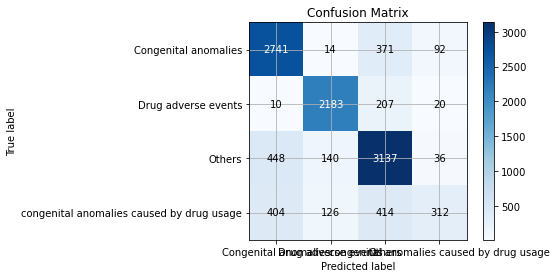

In [67]:
evaluate_features(train_arr, df_train['Label'].values.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


Log loss: 0.5515043071691019
Accuracy: 0.7926794931956828
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.78      0.84      0.81      3218
                      Drug adverse events       0.89      0.91      0.90      2420
                                   Others       0.77      0.82      0.80      3761
congenital anomalies caused by drug usage       0.64      0.37      0.47      1256

                                 accuracy                           0.79     10655
                                macro avg       0.77      0.73      0.74     10655
                             weighted avg       0.79      0.79      0.78     10655



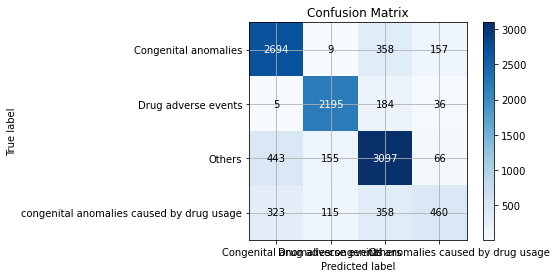

In [68]:
evaluate_features(train_arr, df_train['Label'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Log loss: 0.5371560660866964
Accuracy: 0.8013139371187236
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.76      0.90      0.82      3218
                      Drug adverse events       0.89      0.90      0.90      2420
                                   Others       0.81      0.81      0.81      3761
congenital anomalies caused by drug usage       0.66      0.34      0.45      1256

                                 accuracy                           0.80     10655
                                macro avg       0.78      0.74      0.75     10655
                             weighted avg       0.80      0.80      0.79     10655



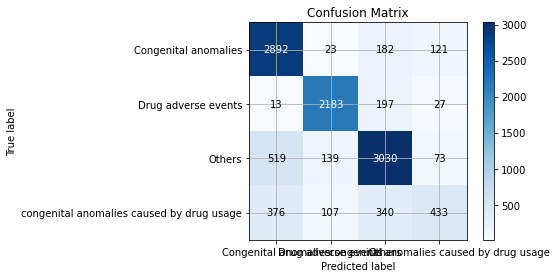

In [69]:
evaluate_features(train_arr, df_train['Label'].values.ravel(),
                  RandomForestClassifier(n_estimators=1000, max_depth=15, verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min finished


Log loss: 0.5783065322386245
Accuracy: 0.7863913655560769
                                           precision    recall  f1-score   support

                     Congenital anomalies       0.74      0.91      0.81      3218
                      Drug adverse events       0.88      0.90      0.89      2420
                                   Others       0.81      0.78      0.79      3761
congenital anomalies caused by drug usage       0.59      0.29      0.39      1256

                                 accuracy                           0.79     10655
                                macro avg       0.75      0.72      0.72     10655
                             weighted avg       0.78      0.79      0.77     10655



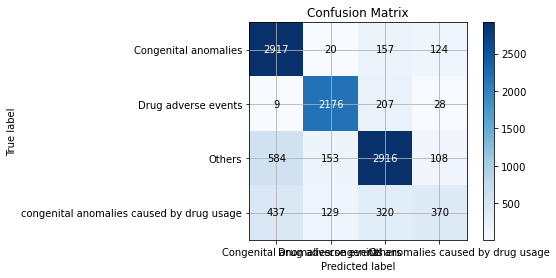

In [70]:
evaluate_features(train_arr,df_train['Label'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,))

In [182]:
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

In [183]:
np.save('traindoc2vec.npy',train_arr)
np.save('testdoc2vec.npy',test_arr)